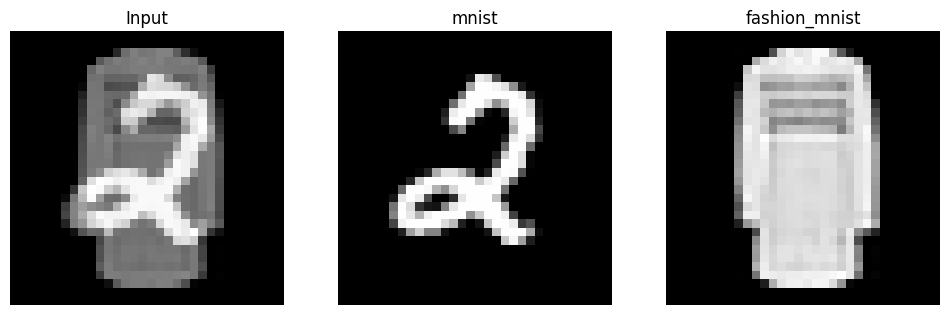

Epoch 1/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 45s 46ms/step - loss: 0.0293 - output1_loss: 0.0135 - output2_loss: 0.0158 - val_loss: 0.0530 - val_output1_loss: 0.0153 - val_output2_loss: 0.0377 - learning_rate: 3.0000e-04
Epoch 2/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 40s 80ms/step - loss: 0.0056 - output1_loss: 0.0025 - output2_loss: 0.0031 - val_loss: 0.0047 - val_output1_loss: 0.0022 - val_output2_loss: 0.0025 - learning_rate: 3.0000e-04
Epoch 3/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - loss: 0.0045 - output1_loss: 0.0020 - output2_loss: 0.0025 - val_loss: 0.0044 - val_output1_loss: 0.0019 - val_output2_loss: 0.0025 - learning_rate: 3.0000e-04
Epoch 4/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step - loss: 0.0038 - output1_loss: 0.0017 - output2_loss: 0.0021 - val_loss: 0.0035 - val_output1_loss: 0.0016 - val_output2_loss: 0.0018 - learning_rate: 3.0000e-04
Epoch 5/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step - loss: 0.0034 - output1_loss: 0.0015 - output2_loss: 0.0019 - val_loss: 0.0032 - 

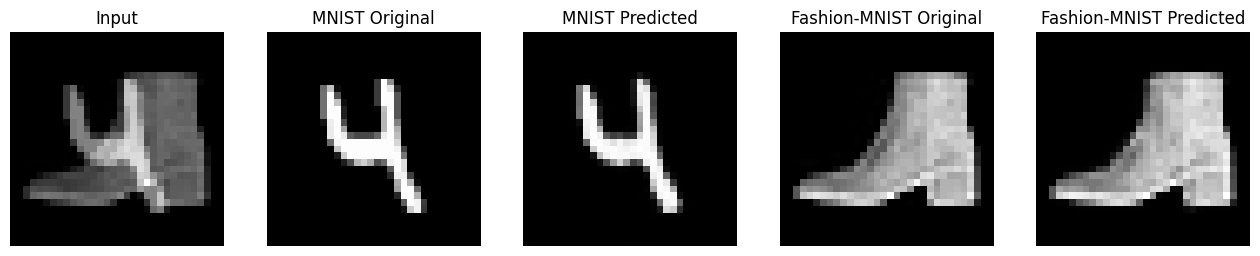

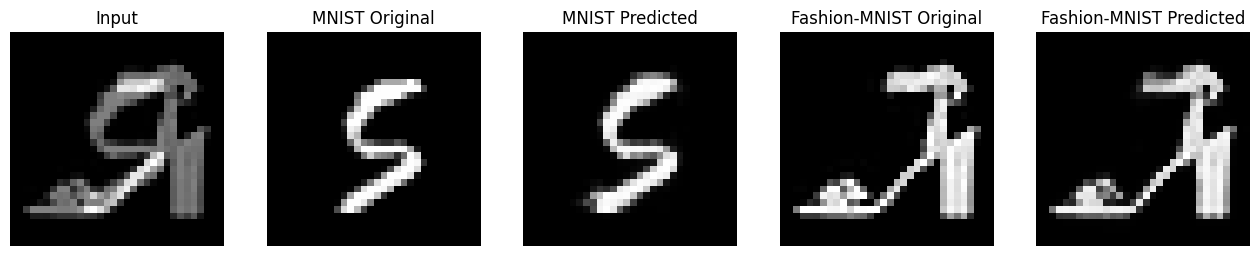

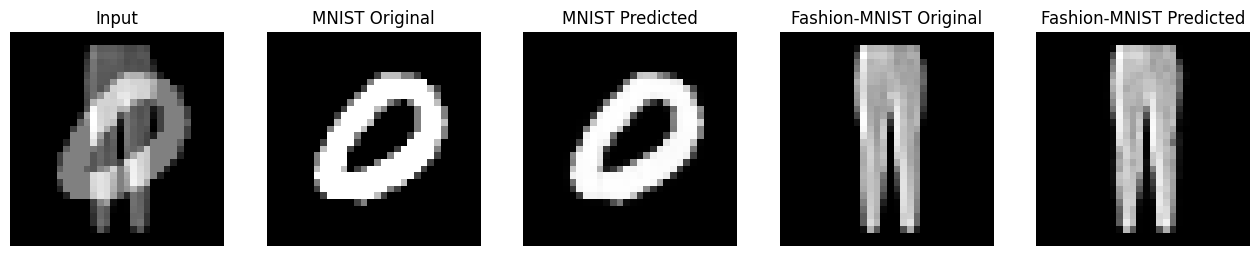

In [1]:
# AUTORE: Francesco Maria Fuligni
# MATRICOLA: 0001068987

import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist, fashion_mnist
import tensorflow.image as tfi



# CARICAMENTO DEI DATASET
# MNIST contiene immagini di cifre scritte a mano
# Fashion-MNIST contiene immagini di articoli di moda
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
(fashion_mnist_x_train, fashion_mnist_y_train), (fashion_mnist_x_test, fashion_mnist_y_test) = fashion_mnist.load_data()



# NORMALIZZAZIONE DEI DATI DI TRAINING E DI TEST
# Padding delle immagini per portarle a 32x32 px e normalizzazione in modo che i
# valori dei pixel siano compresi tra 0 e 1
mnist_x_train = np.pad(mnist_x_train,((0,0),(2,2),(2,2)))/255.
mnist_x_test = np.pad(mnist_x_test,((0,0),(2,2),(2,2)))/255.

fashion_mnist_x_train = np.pad(fashion_mnist_x_train,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_test = np.pad(fashion_mnist_x_test,((0,0),(2,2),(2,2)))/255.



# GENERATORE DI DATI
# Seleziona randomicamente coppie di immagini dai due dataset e le somma pixel
# per pixel. Le due immagini originali sono gli output desiderati
def datagenerator(x1,x2,batchsize):
    n1 = x1.shape[0]
    n2 = x2.shape[0]
    while True:
        num1 = np.random.randint(0, n1, batchsize)
        num2 = np.random.randint(0, n2, batchsize)

        x_data = (x1[num1] + x2[num2]) / 2.0
        y_data = (x1[num1], x2[num2])

        yield x_data, y_data

# Generatore di batchsize 1
onegen = datagenerator(mnist_x_test, fashion_mnist_x_test, 1)

# VISUALIZZAZIONE DI UN ESEMPIO DAL GENERATORE DI DATI
def show_images(x,y1,y2):
    fig, ax = plt.subplots(1,3,figsize=(12,4))
    ax[0].imshow(x,cmap='gray')
    ax[0].title.set_text('Input')
    ax[0].axis('off')
    ax[1].imshow(y1,cmap='gray')
    ax[1].title.set_text('mnist')
    ax[1].axis('off')
    ax[2].imshow(y2,cmap='gray')
    ax[2].title.set_text('fashion_mnist')
    ax[2].axis('off')
    plt.show()

x,(y1,y2)=next(onegen)
show_images(x[0],y1[0],y2[0])



# MODELLO CNN
# Definzione del modello CNN con struttura encoder-decoder
# Encoder estrae caratteristiche significative comprimendo l'input
# Bottleneck riduce ulteriormente le dimensioni mantenendo solo le feature più importanti
# Decoder ricostruisce le immagini separate a partire dalla rappresentazione codificata
# Decoder separati per MNIST e Fashion MNIST
def my_model():
    input_img = layers.Input(shape=(32, 32, 1))

    # Encoder
    x1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x1 = layers.BatchNormalization()(x1)
    x1_pool = layers.MaxPooling2D((2, 2), padding='same')(x1)

    x2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x1_pool)
    x2 = layers.BatchNormalization()(x2)
    x2_pool = layers.MaxPooling2D((2, 2), padding='same')(x2)

    # Bottleneck
    x3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x2_pool)
    x3 = layers.BatchNormalization()(x3)

    # Decoder per MNIST
    d1 = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x3)
    d1 = layers.BatchNormalization()(d1)
    d1 = layers.UpSampling2D((2, 2))(d1)
    d1 = layers.Concatenate()([d1, x2])
    d1 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(d1)
    d1 = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(d1)
    d1 = layers.BatchNormalization()(d1)
    d1 = layers.UpSampling2D((2, 2))(d1)
    d1 = layers.Concatenate()([d1, x1])
    d1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(d1)
    output1 = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='output1')(d1)

    # Decoder per Fashion MNIST
    d2 = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x3)
    d2 = layers.BatchNormalization()(d2)
    d2 = layers.UpSampling2D((2, 2))(d2)
    d2 = layers.Concatenate()([d2, x2])
    d2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(d2)
    d2 = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(d2)
    d2 = layers.BatchNormalization()(d2)
    d2 = layers.UpSampling2D((2, 2))(d2)
    d2 = layers.Concatenate()([d2, x1])
    d2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(d2)
    output2 = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='output2')(d2)


    model = models.Model(input_img, [output1, output2])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003), loss='mse')
    return model



# CREAZIONE E ADDESTRAMENTO DEL MODELLO
# ReduceLR riduce il learning rate se la loss smette di migliorare
# EarlyStopping interrompe il training se non ci sono miglioramenti (per evitare overfitting)
batchsize = 64
epochs = 30
model = my_model()

# Divisione in validation e test set
num_training_samples_total = mnist_x_train.shape[0]
num_validation_samples = int(0.2 * num_training_samples_total) # 20% per la validation
num_training_samples = num_training_samples_total - num_validation_samples # 80% per il training

testgen = datagenerator(mnist_x_train[:num_training_samples], fashion_mnist_x_train[:num_training_samples], batchsize)
valgen = datagenerator(mnist_x_train[num_training_samples:num_training_samples_total], fashion_mnist_x_train[num_training_samples:num_training_samples_total], batchsize)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit(testgen, steps_per_epoch=1000, epochs=epochs, validation_data=valgen, validation_steps=200, verbose=1, callbacks=[reduce_lr, early_stopping])



# FUNZIONE DI VALUTAZIONE
# np.squeeze evita errori dovuti alla dimensione dei tensori
def eval_model(model):
    x, (y1, y2) = next(testgen)
    pred1, pred2 = model(x)

    pred1 = np.squeeze(pred1)
    pred2 = np.squeeze(pred2)
    y1 = np.squeeze(y1)
    y2 = np.squeeze(y2)

    return ( np.mean((pred1 - y1) ** 2) + np.mean((pred2 - y2) ** 2)) / 2

# Valutazione del modello
repeat_eval = epochs
eval_results = []
for i in range(repeat_eval):
    eval_results.append(eval_model(model))

# Stampa delle metriche di valutazione (MSE e STD DEV)
print("MSE = ", np.mean(eval_results))
print("Standard deviation = ", np.std(eval_results))



# VISUALIZZAZIONE DI ESEMPI DI RISULTATI PREDETTI DAL MODELLO
def visualize_predictions(model, num_examples=3):
    for i in range(num_examples):
        x, (y1, y2) = next(onegen)
        pred1, pred2 = model.predict(x, verbose=0)

        x = np.squeeze(x[0])
        y1 = np.squeeze(y1[0])
        y2 = np.squeeze(y2[0])
        pred1 = np.squeeze(pred1[0])
        pred2 = np.squeeze(pred2[0])

        fig, ax = plt.subplots(1, 5, figsize=(16, 4))
        ax[0].imshow(x, cmap='gray')
        ax[0].set_title("Input")
        ax[0].axis('off')

        ax[1].imshow(y1, cmap='gray')
        ax[1].set_title("MNIST Original")
        ax[1].axis('off')

        ax[2].imshow(pred1, cmap='gray')
        ax[2].set_title("MNIST Predicted")
        ax[2].axis('off')

        ax[3].imshow(y2, cmap='gray')
        ax[3].set_title("Fashion-MNIST Original")
        ax[3].axis('off')

        ax[4].imshow(pred2, cmap='gray')
        ax[4].set_title("Fashion-MNIST Predicted")
        ax[4].axis('off')

        plt.show()

# Visualizzazione di 3 esempi
visualize_predictions(model, num_examples=3)
